
# DFT Demo: manual DFT with sin/cos tables, reconstruction, FFT comparison, and plots

Этот ноутбук содержит:
- реализацию DFT для отдельной гармоники и полного спектра с использованием таблиц sin/cos;
- генерацию тестовых сигналов (одногармонического и полигармонического);
- восстановление сигнала по спектру (с фазами и без фаз);
- сравнение с `numpy.fft.rfft` и простую фильтрацию в частотной области;
- графики и численные метрики (MSE, max error).

Запустите все ячейки последовательно (Kernel → Restart & Run All) для получения тех же результатов, что и в демонстрации.


In [33]:

import numpy as np
import matplotlib.pyplot as plt
from math import pi
import time
np.random.seed(1)


In [34]:

def make_sin_cos_tables(N):
    k = np.arange(N)
    ang = 2*np.pi*k/N
    return np.cos(ang), np.sin(ang)

def dft_harmonic(x, N, j, cos_table, sin_table):
    Ac = 0.0
    As = 0.0
    for i in range(N):
        idx = (j * i) % N
        Ac += x[i] * cos_table[idx]
        As += x[i] * sin_table[idx]
    Ac *= 2.0 / N
    As *= 2.0 / N
    A = np.sqrt(Ac*Ac + As*As)
    phi = np.arctan2(As, Ac)
    return Ac, As, A, phi

def spectrum_all(x, N, cos_table, sin_table):
    max_j = N//2
    Acs = np.zeros(max_j)
    Ass = np.zeros(max_j)
    A = np.zeros(max_j)
    phi = np.zeros(max_j)
    for j in range(max_j):
        Acs[j], Ass[j], A[j], phi[j] = dft_harmonic(x, N, j, cos_table, sin_table)
    return Acs, Ass, A, phi

def reconstruct_from_A_phi(A, phi, N):
    max_j = len(A)
    y = np.zeros(N)
    if max_j > 0:
        y += A[0]/2.0
    for j in range(1, max_j):
        for i in range(N):
            y[i] += A[j]*np.cos(2*np.pi*j*i/N - phi[j])
    return y

def compare_with_fft(x, N):
    X = np.fft.rfft(x)
    A_fft = (2.0/N) * np.abs(X)
    return A_fft[:N//2], X[:N//2]


In [35]:
def my_fft(x):
    """
    Собственная реализация быстрого преобразования Фурье (FFT)
    Использует алгоритм Cooley-Tukey для N = 2^k
    """
    N = len(x)
    
    # Проверяем, что N является степенью двойки
    if N & (N - 1) != 0:
        raise ValueError("N должно быть степенью двойки для FFT")
    
    # Базовый случай
    if N == 1:
        return x
    
    # Рекурсивно вычисляем FFT для четных и нечетных индексов
    even = my_fft(x[::2])
    odd = my_fft(x[1::2])
    
    # Объединяем результаты
    result = np.zeros(N, dtype=complex)
    for k in range(N // 2):
        t = np.exp(-2j * np.pi * k / N) * odd[k]
        result[k] = even[k] + t
        result[k + N // 2] = even[k] - t
    
    return result

def my_ifft(X):
    """
    Обратное быстрое преобразование Фурье (IFFT)
    """
    N = len(X)
    
    # IFFT через FFT с комплексным сопряжением
    x_conj = my_fft(np.conj(X))
    return np.conj(x_conj) / N

def compare_fft_implementations(x):
    """
    Сравнение собственной реализации FFT с numpy.fft.fft
    """
    N = len(x)
    
    # Собственная реализация
    t0 = time.time()
    X_my = my_fft(x)
    t_my = time.time() - t0
    
    # NumPy реализация
    t0 = time.time()
    X_np = np.fft.fft(x)
    t_np = time.time() - t0
    
    # Вычисляем ошибку
    error = np.max(np.abs(X_my - X_np))
    
    print(f"Сравнение FFT (N={N}):")
    print(f"  Собственная реализация: {t_my:.6f}s")
    print(f"  NumPy FFT: {t_np:.6f}s")
    print(f"  Максимальная ошибка: {error:.2e}")
    
    return X_my, X_np, error


In [36]:
def low_pass_filter(x, cutoff_freq, N):
    """
    НЧ-фильтр через удаление высокочастотных компонент в частотной области
    
    Параметры:
    x - входной сигнал
    cutoff_freq - частота среза (от 0 до 0.5)
    N - размер FFT
    """
    # Вычисляем FFT
    X = my_fft(x)
    
    # Создаем маску для НЧ-фильтра
    mask = np.zeros(N, dtype=bool)
    cutoff_bin = int(cutoff_freq * N)
    mask[:cutoff_bin] = True
    mask[N-cutoff_bin:] = True  # Для симметрии
    
    # Применяем маску
    X_filtered = X * mask
    
    # Обратное преобразование
    x_filtered = np.real(my_ifft(X_filtered))
    
    return x_filtered, X_filtered

def high_pass_filter(x, cutoff_freq, N):
    """
    ВЧ-фильтр через удаление низкочастотных компонент в частотной области
    
    Параметры:
    x - входной сигнал
    cutoff_freq - частота среза (от 0 до 0.5)
    N - размер FFT
    """
    # Вычисляем FFT
    X = my_fft(x)
    
    # Создаем маску для ВЧ-фильтра
    mask = np.ones(N, dtype=bool)
    cutoff_bin = int(cutoff_freq * N)
    mask[:cutoff_bin] = False
    mask[N-cutoff_bin:] = False  # Для симметрии
    
    # Применяем маску
    X_filtered = X * mask
    
    # Обратное преобразование
    x_filtered = np.real(my_ifft(X_filtered))
    
    return x_filtered, X_filtered

def band_pass_filter(x, low_cutoff, high_cutoff, N):
    """
    Полосовой фильтр - пропускает частоты в заданном диапазоне
    
    Параметры:
    x - входной сигнал
    low_cutoff - нижняя частота среза (от 0 до 0.5)
    high_cutoff - верхняя частота среза (от 0 до 0.5)
    N - размер FFT
    """
    # Вычисляем FFT
    X = my_fft(x)
    
    # Создаем маску для полосового фильтра
    mask = np.zeros(N, dtype=bool)
    low_bin = int(low_cutoff * N)
    high_bin = int(high_cutoff * N)
    mask[low_bin:high_bin] = True
    mask[N-high_bin:N-low_bin] = True  # Для симметрии
    
    # Применяем маску
    X_filtered = X * mask
    
    # Обратное преобразование
    x_filtered = np.real(my_ifft(X_filtered))
    
    return x_filtered, X_filtered

def band_stop_filter(x, low_cutoff, high_cutoff, N):
    """
    Режекторный фильтр - подавляет частоты в заданном диапазоне
    
    Параметры:
    x - входной сигнал
    low_cutoff - нижняя частота подавления (от 0 до 0.5)
    high_cutoff - верхняя частота подавления (от 0 до 0.5)
    N - размер FFT
    """
    # Вычисляем FFT
    X = my_fft(x)
    
    # Создаем маску для режекторного фильтра
    mask = np.ones(N, dtype=bool)
    low_bin = int(low_cutoff * N)
    high_bin = int(high_cutoff * N)
    mask[low_bin:high_bin] = False
    mask[N-high_bin:N-low_bin] = False  # Для симметрии
    
    # Применяем маску
    X_filtered = X * mask
    
    # Обратное преобразование
    x_filtered = np.real(my_ifft(X_filtered))
    
    return x_filtered, X_filtered


In [37]:
def create_test_signal(N):
    """
    Создает тестовый сигнал с несколькими гармониками для демонстрации фильтрации
    """
    i = np.arange(N)
    
    # Низкочастотная компонента
    low_freq = 2.0 * np.cos(2 * np.pi * 5 * i / N)
    
    # Среднечастотная компонента  
    mid_freq = 1.5 * np.cos(2 * np.pi * 20 * i / N)
    
    # Высокочастотная компонента
    high_freq = 1.0 * np.cos(2 * np.pi * 40 * i / N)
    
    # Шум
    noise = 0.1 * np.random.randn(N)
    
    # Суммарный сигнал
    signal = low_freq + mid_freq + high_freq + noise
    
    return signal, low_freq, mid_freq, high_freq, noise

def demo_filters(N=128):
    """
    Демонстрация работы цифровых фильтров
    """
    print(f"=== Демонстрация цифровых фильтров (N={N}) ===")
    
    # Создаем тестовый сигнал
    signal, low_freq, mid_freq, high_freq, noise = create_test_signal(N)
    
    # Применяем различные фильтры
    print("\n1. НЧ-фильтр (частота среза = 0.1)")
    signal_lp, X_lp = low_pass_filter(signal, 0.1, N)
    
    print("2. ВЧ-фильтр (частота среза = 0.2)")  
    signal_hp, X_hp = high_pass_filter(signal, 0.2, N)
    
    print("3. Полосовой фильтр (0.15 - 0.3)")
    signal_bp, X_bp = band_pass_filter(signal, 0.15, 0.3, N)
    
    print("4. Режекторный фильтр (0.15 - 0.3)")
    signal_bs, X_bs = band_stop_filter(signal, 0.15, 0.3, N)
    
    # Вычисляем спектры для визуализации
    X_original = my_fft(signal)
    freqs = np.arange(N) / N
    
    # Строим графики
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Временная область
    i = np.arange(N)
    axes[0, 0].plot(i, signal, 'b-', label='Исходный сигнал', alpha=0.7)
    axes[0, 0].plot(i, signal_lp, 'r-', label='НЧ-фильтр', linewidth=2)
    axes[0, 0].set_title('НЧ-фильтр (частота среза = 0.1)')
    axes[0, 0].set_xlabel('Время'); axes[0, 0].set_ylabel('Амплитуда')
    axes[0, 0].legend(); axes[0, 0].grid(True)
    
    axes[0, 1].plot(i, signal, 'b-', label='Исходный сигнал', alpha=0.7)
    axes[0, 1].plot(i, signal_hp, 'g-', label='ВЧ-фильтр', linewidth=2)
    axes[0, 1].set_title('ВЧ-фильтр (частота среза = 0.2)')
    axes[0, 1].set_xlabel('Время'); axes[0, 1].set_ylabel('Амплитуда')
    axes[0, 1].legend(); axes[0, 1].grid(True)
    
    # Частотная область - амплитудный спектр
    axes[1, 0].plot(freqs[:N//2], np.abs(X_original[:N//2]), 'b-', label='Исходный', alpha=0.7)
    axes[1, 0].plot(freqs[:N//2], np.abs(X_lp[:N//2]), 'r-', label='НЧ-фильтр', linewidth=2)
    axes[1, 0].set_title('Амплитудный спектр - НЧ-фильтр')
    axes[1, 0].set_xlabel('Частота'); axes[1, 0].set_ylabel('|X(f)|')
    axes[1, 0].legend(); axes[1, 0].grid(True)
    
    axes[1, 1].plot(freqs[:N//2], np.abs(X_original[:N//2]), 'b-', label='Исходный', alpha=0.7)
    axes[1, 1].plot(freqs[:N//2], np.abs(X_hp[:N//2]), 'g-', label='ВЧ-фильтр', linewidth=2)
    axes[1, 1].set_title('Амплитудный спектр - ВЧ-фильтр')
    axes[1, 1].set_xlabel('Частота'); axes[1, 1].set_ylabel('|X(f)|')
    axes[1, 1].legend(); axes[1, 1].grid(True)
    
    # Полосовой и режекторный фильтры
    axes[2, 0].plot(i, signal, 'b-', label='Исходный сигнал', alpha=0.7)
    axes[2, 0].plot(i, signal_bp, 'm-', label='Полосовой фильтр', linewidth=2)
    axes[2, 0].set_title('Полосовой фильтр (0.15 - 0.3)')
    axes[2, 0].set_xlabel('Время'); axes[2, 0].set_ylabel('Амплитуда')
    axes[2, 0].legend(); axes[2, 0].grid(True)
    
    axes[2, 1].plot(i, signal, 'b-', label='Исходный сигнал', alpha=0.7)
    axes[2, 1].plot(i, signal_bs, 'c-', label='Режекторный фильтр', linewidth=2)
    axes[2, 1].set_title('Режекторный фильтр (0.15 - 0.3)')
    axes[2, 1].set_xlabel('Время'); axes[2, 1].set_ylabel('Амплитуда')
    axes[2, 1].legend(); axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Вычисляем метрики качества фильтрации
    print("\n=== Метрики качества фильтрации ===")
    print(f"НЧ-фильтр - MSE: {np.mean((signal - signal_lp)**2):.6f}")
    print(f"ВЧ-фильтр - MSE: {np.mean((signal - signal_hp)**2):.6f}")
    print(f"Полосовой фильтр - MSE: {np.mean((signal - signal_bp)**2):.6f}")
    print(f"Режекторный фильтр - MSE: {np.mean((signal - signal_bs)**2):.6f}")
    
    return {
        'signal': signal,
        'low_pass': signal_lp,
        'high_pass': signal_hp, 
        'band_pass': signal_bp,
        'band_stop': signal_bs,
        'X_original': X_original,
        'X_lp': X_lp,
        'X_hp': X_hp,
        'X_bp': X_bp,
        'X_bs': X_bs
    }


In [38]:
def test_different_sizes():
    """
    Тестирование на разных размерах N (128, 256, 512, 1024)
    """
    sizes = [128, 256, 512, 1024]
    
    print("=== Тестирование на разных размерах N ===")
    print("Размер\tDFT время\tFFT время\tFFT ошибка\tФильтрация время")
    print("-" * 70)
    
    results = {}
    
    for N in sizes:
        # Создаем тестовый сигнал
        x, _, _, _, _ = create_test_signal(N)
        
        # Тестируем DFT
        cos_table, sin_table = make_sin_cos_tables(N)
        t0 = time.time()
        _, _, A, phi = spectrum_all(x, N, cos_table, sin_table)
        t_dft = time.time() - t0
        
        # Тестируем FFT
        t0 = time.time()
        X_my = my_fft(x)
        t_my_fft = time.time() - t0
        
        t0 = time.time()
        X_np = np.fft.fft(x)
        t_np_fft = time.time() - t0
        
        fft_error = np.max(np.abs(X_my - X_np))
        
        # Тестируем фильтрацию
        t0 = time.time()
        _, _ = low_pass_filter(x, 0.1, N)
        t_filter = time.time() - t0
        
        print(f"{N}\t{t_dft:.4f}s\t\t{t_my_fft:.6f}s\t\t{fft_error:.2e}\t\t{t_filter:.6f}s")
        
        results[N] = {
            'dft_time': t_dft,
            'fft_time': t_my_fft,
            'fft_error': fft_error,
            'filter_time': t_filter
        }
    
    return results

def comprehensive_demo():
    """
    Комплексная демонстрация всех возможностей
    """
    print("=== КОМПЛЕКСНАЯ ДЕМОНСТРАЦИЯ ===")
    print("1. Тестирование FFT")
    print("2. Демонстрация фильтров")
    print("3. Тестирование на разных размерах")
    print("4. Сравнение с оригинальным заданием")
    
    # 1. Тестирование FFT
    print("\n" + "="*50)
    print("1. ТЕСТИРОВАНИЕ FFT")
    print("="*50)
    
    # Создаем тестовый сигнал для FFT
    N_test = 128
    x_test = single_tone(N_test)
    X_my, X_np, error = compare_fft_implementations(x_test)
    
    # 2. Демонстрация фильтров
    print("\n" + "="*50)
    print("2. ДЕМОНСТРАЦИЯ ФИЛЬТРОВ")
    print("="*50)
    
    filter_results = demo_filters(N_test)
    
    # 3. Тестирование на разных размерах
    print("\n" + "="*50)
    print("3. ТЕСТИРОВАНИЕ НА РАЗНЫХ РАЗМЕРАХ")
    print("="*50)
    
    size_results = test_different_sizes()
    
    # 4. Оригинальное задание
    print("\n" + "="*50)
    print("4. ОРИГИНАЛЬНОЕ ЗАДАНИЕ (DFT + ВОССТАНОВЛЕНИЕ)")
    print("="*50)
    
    original_results = demo(N=128, J=30, plot=True)
    
    return {
        'fft_test': (X_my, X_np, error),
        'filter_demo': filter_results,
        'size_test': size_results,
        'original_demo': original_results
    }


=== КОМПЛЕКСНАЯ ДЕМОНСТРАЦИЯ ===
1. Тестирование FFT
2. Демонстрация фильтров
3. Тестирование на разных размерах
4. Сравнение с оригинальным заданием

1. ТЕСТИРОВАНИЕ FFT
Сравнение FFT (N=128):
  Собственная реализация: 0.000824s
  NumPy FFT: 0.000186s
  Максимальная ошибка: 2.60e-13

2. ДЕМОНСТРАЦИЯ ФИЛЬТРОВ
=== Демонстрация цифровых фильтров (N=128) ===

1. НЧ-фильтр (частота среза = 0.1)
2. ВЧ-фильтр (частота среза = 0.2)
3. Полосовой фильтр (0.15 - 0.3)
4. Режекторный фильтр (0.15 - 0.3)


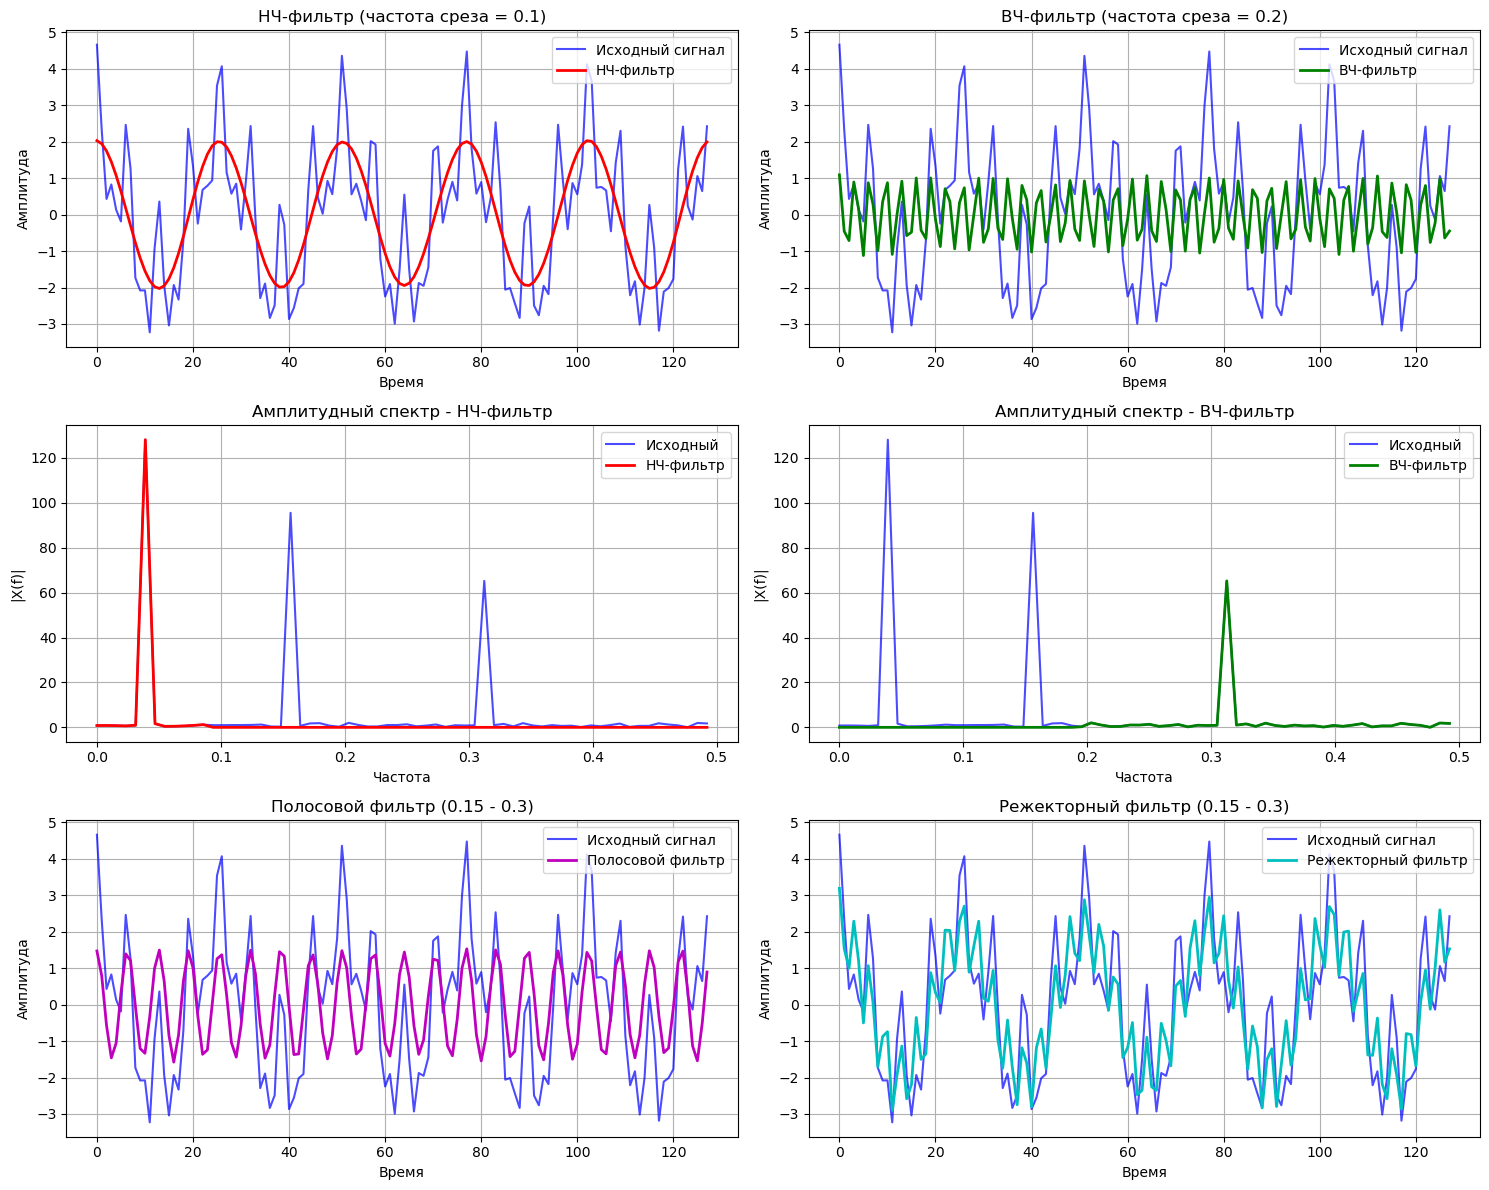


=== Метрики качества фильтрации ===
НЧ-фильтр - MSE: 1.641359
ВЧ-фильтр - MSE: 3.122383
Полосовой фильтр - MSE: 2.529381
Режекторный фильтр - MSE: 1.117573

3. ТЕСТИРОВАНИЕ НА РАЗНЫХ РАЗМЕРАХ
=== Тестирование на разных размерах N ===
Размер	DFT время	FFT время	FFT ошибка	Фильтрация время
----------------------------------------------------------------------
128	0.0024s		0.000520s		5.91e-14		0.000966s
256	0.0101s		0.001192s		1.21e-13		0.002144s
512	0.0436s		0.002469s		2.62e-13		0.004963s
1024	0.1639s		0.005194s		6.23e-13		0.010246s

4. ОРИГИНАЛЬНОЕ ЗАДАНИЕ (DFT + ВОССТАНОВЛЕНИЕ)


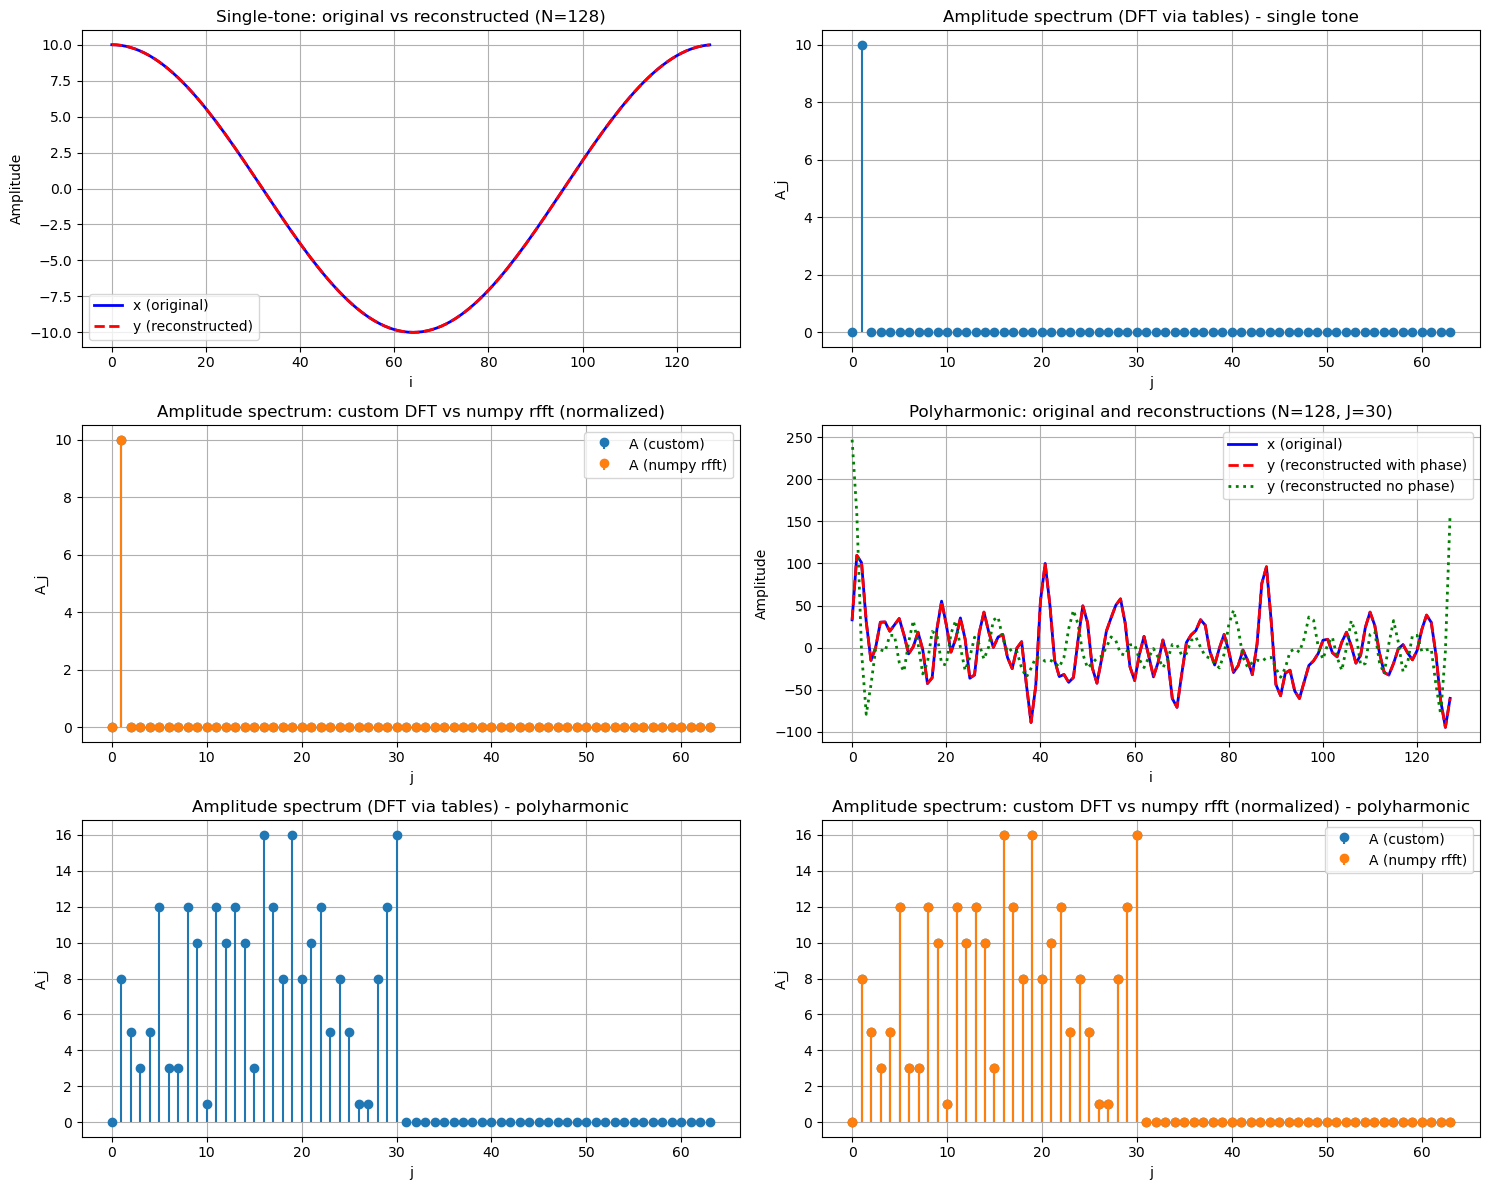

Single-tone reconstruction: MSE = 3.125e-30, max abs error = 7.105e-15
Polyharmonic reconstruction: MSE = 6.876e-26, max abs error = 1.059e-12
Polyharmonic reconstruction (no phase): MSE = 2.358e+03, max abs error = 2.190e+02
Timing (N=128): full DFT (table) = 0.0028s, numpy rfft = 0.000039s


In [39]:
# Запуск комплексной демонстрации всех возможностей
# Включает: FFT, фильтрацию, тестирование на разных N, оригинальное задание
results = comprehensive_demo()


In [40]:

def single_tone(N):
    i = np.arange(N)
    return 10.0 * np.cos(2*np.pi * i / N)

def polyharmonic(N, J=30, amplitude_choices=None, phase_choices=None):
    if amplitude_choices is None:
        amplitude_choices = [1,3,5,8,10,12,16]
    if phase_choices is None:
        phase_choices = [pi/6, pi/4, pi/3, pi/2, 3*pi/4, pi]
    i = np.arange(N)
    x = np.zeros(N)
    B = np.random.choice(amplitude_choices, size=J)
    ph = np.random.choice(phase_choices, size=J)
    for j in range(1, J+1):
        x += B[j-1] * np.cos(2*np.pi*j*i/N - ph[j-1])
    return x, B, ph


In [41]:

def demo(N=128, J=30, plot=True):
    """
    Демонстрация DFT, восстановления сигналов и сравнения с FFT
    Все графики отображаются на одном канвасе
    """
    cos_table, sin_table = make_sin_cos_tables(N)
    results = {}
    
    # Single tone
    x1 = single_tone(N)
    Acs1, Ass1, A1, phi1 = spectrum_all(x1, N, cos_table, sin_table)
    y1 = reconstruct_from_A_phi(A1, phi1, N)
    A_fft_1, X1 = compare_with_fft(x1, N)
    mse1 = np.mean((x1 - y1)**2)
    max_err1 = np.max(np.abs(x1 - y1))
    results['single'] = dict(N=N, x=x1, y=y1, A=A1, phi=phi1, A_fft=A_fft_1,
                             mse=mse1, max_err=max_err1)

    # Polyharmonic
    x2, B, ph = polyharmonic(N, J=J)
    Acs2, Ass2, A2, phi2 = spectrum_all(x2, N, cos_table, sin_table)
    y2 = reconstruct_from_A_phi(A2, phi2, N)
    y2_no_phase = reconstruct_from_A_phi(A2, np.zeros_like(phi2), N)
    A_fft_2, X2 = compare_with_fft(x2, N)
    mse2 = np.mean((x2 - y2)**2)
    max_err2 = np.max(np.abs(x2 - y2))
    mse2_no_phase = np.mean((x2 - y2_no_phase)**2)
    max_err2_no_phase = np.max(np.abs(x2 - y2_no_phase))
    results['poly'] = dict(N=N, x=x2, y=y2, y_no_phase=y2_no_phase,
                           A=A2, phi=phi2, B=B, ph=ph,
                           A_fft=A_fft_2, mse=mse2, max_err=max_err2,
                           mse_no_phase=mse2_no_phase, max_err_no_phase=max_err2_no_phase)

    if plot:
        # Создаем единый канвас с 6 подграфиками
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        
        # 1. Одногармонический сигнал - восстановление
        i = np.arange(N)
        axes[0, 0].plot(i, x1, 'b-', label='x (original)', linewidth=2)
        axes[0, 0].plot(i, y1, 'r--', label='y (reconstructed)', linewidth=2)
        axes[0, 0].set_title(f'Single-tone: original vs reconstructed (N={N})')
        axes[0, 0].set_xlabel('i'); axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].legend(); axes[0, 0].grid(True)
        
        # 2. Одногармонический сигнал - амплитудный спектр
        js = np.arange(len(A1))
        axes[0, 1].stem(js, A1, basefmt=" ", label='A (DFT table)')
        axes[0, 1].set_title('Amplitude spectrum (DFT via tables) - single tone')
        axes[0, 1].set_xlabel('j'); axes[0, 1].set_ylabel('A_j')
        axes[0, 1].grid(True)
        
        # 3. Одногармонический сигнал - сравнение с FFT
        axes[1, 0].stem(js, A1, basefmt=" ", label='A (custom)')
        axes[1, 0].stem(js, A_fft_1, basefmt=" ", markerfmt='C1o', linefmt='C1-', label='A (numpy rfft)')
        axes[1, 0].set_title('Amplitude spectrum: custom DFT vs numpy rfft (normalized)')
        axes[1, 0].set_xlabel('j'); axes[1, 0].set_ylabel('A_j')
        axes[1, 0].legend(); axes[1, 0].grid(True)
        
        # 4. Полигармонический сигнал - восстановление
        axes[1, 1].plot(i, x2, 'b-', label='x (original)', linewidth=2)
        axes[1, 1].plot(i, y2, 'r--', label='y (reconstructed with phase)', linewidth=2)
        axes[1, 1].plot(i, y2_no_phase, 'g:', label='y (reconstructed no phase)', linewidth=2)
        axes[1, 1].set_title(f'Polyharmonic: original and reconstructions (N={N}, J={J})')
        axes[1, 1].set_xlabel('i'); axes[1, 1].set_ylabel('Amplitude')
        axes[1, 1].legend(); axes[1, 1].grid(True)
        
        # 5. Полигармонический сигнал - амплитудный спектр
        js2 = np.arange(len(A2))
        axes[2, 0].stem(js2, A2, basefmt=" ", label='A (DFT table)')
        axes[2, 0].set_title('Amplitude spectrum (DFT via tables) - polyharmonic')
        axes[2, 0].set_xlabel('j'); axes[2, 0].set_ylabel('A_j')
        axes[2, 0].grid(True)
        
        # 6. Полигармонический сигнал - сравнение с FFT
        axes[2, 1].stem(js2, A2, basefmt=" ", label='A (custom)')
        axes[2, 1].stem(js2, A_fft_2, basefmt=" ", markerfmt='C1o', linefmt='C1-', label='A (numpy rfft)')
        axes[2, 1].set_title('Amplitude spectrum: custom DFT vs numpy rfft (normalized) - polyharmonic')
        axes[2, 1].set_xlabel('j'); axes[2, 1].set_ylabel('A_j')
        axes[2, 1].legend(); axes[2, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

    print("Single-tone reconstruction: MSE = {:.3e}, max abs error = {:.3e}".format(mse1, max_err1))
    print("Polyharmonic reconstruction: MSE = {:.3e}, max abs error = {:.3e}".format(mse2, max_err2))
    print("Polyharmonic reconstruction (no phase): MSE = {:.3e}, max abs error = {:.3e}".format(mse2_no_phase, max_err2_no_phase))

    # timing
    t0 = time.time(); _ = spectrum_all(x2, N, cos_table, sin_table); t1 = time.time(); t_dft = t1 - t0
    t0 = time.time(); _ = np.fft.rfft(x2); t1 = time.time(); t_fft = t1 - t0
    print("Timing (N={}): full DFT (table) = {:.4f}s, numpy rfft = {:.6f}s".format(N, t_dft, t_fft))

    return results


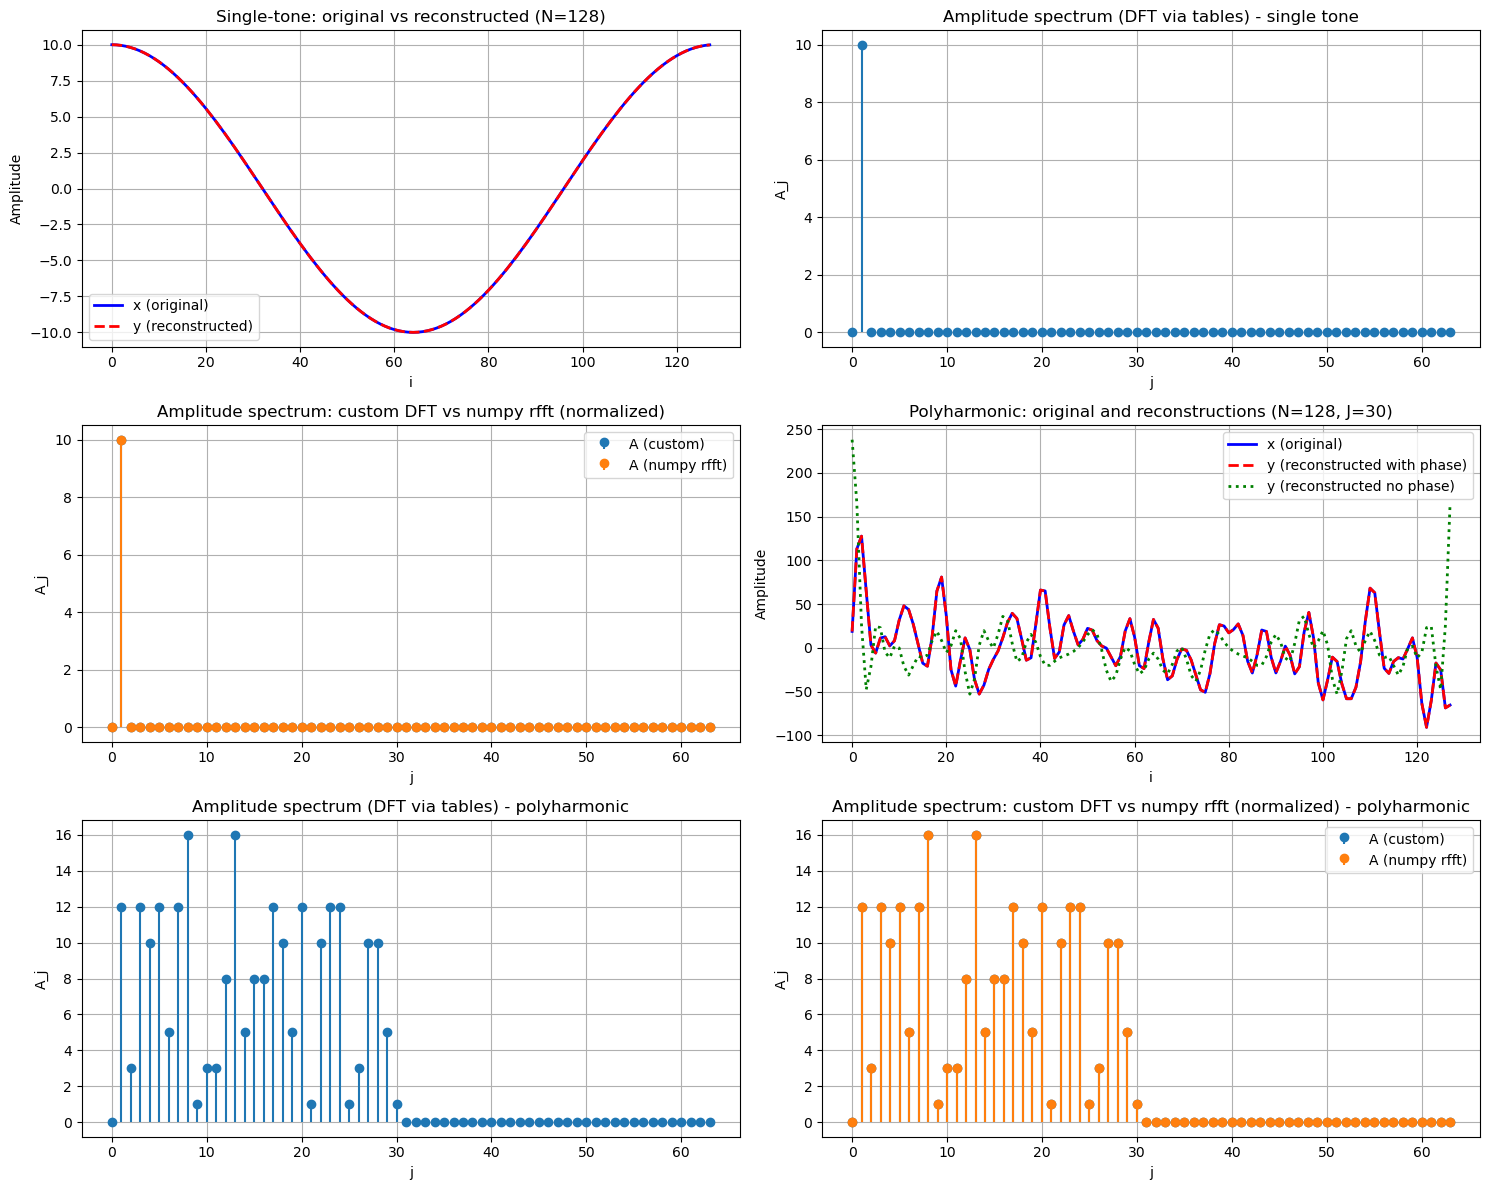

Single-tone reconstruction: MSE = 3.125e-30, max abs error = 7.105e-15
Polyharmonic reconstruction: MSE = 2.022e-26, max abs error = 4.086e-13
Polyharmonic reconstruction (no phase): MSE = 2.261e+03, max abs error = 2.310e+02
Timing (N=128): full DFT (table) = 0.0027s, numpy rfft = 0.000051s


In [42]:

# Run demo with default parameters
results = demo(N=128, J=30, plot=True)
